In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cleaned-data-med/mtsamples_cleaned (2).csv


In [2]:
pip install sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 3.6 MB/s eta 0:00:0000:0100:01m
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
from torch.utils.data import DataLoader
from datasets import Dataset
import pandas as pd
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForCausalLM
tokenizer = AutoTokenizer.from_pretrained("microsoft/biogpt")
model = AutoModelForCausalLM.from_pretrained("microsoft/biogpt")

config.json:   0%|          | 0.00/595 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/927k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/696k [00:00<?, ?B/s]

2025-05-04 08:27:31.247141: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746347251.427121      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746347251.480025      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

In [4]:
# Load your dataset
df = pd.read_csv('/kaggle/input/cleaned-data-med/mtsamples_cleaned (2).csv')

# Convert the dataset into the Hugging Face Dataset format
def preprocess_function(examples):
    # Tokenize the inputs (assuming 'Transcriptions' is your input text)
    return tokenizer(examples['transcription'], truncation=True, padding='max_length', max_length=512)

# Prepare dataset for training
dataset = Dataset.from_pandas(df[['transcription']])
dataset = dataset.map(preprocess_function, batched=True)

# Ensure the dataset returns the correct format for DataLoader
def collate_fn(batch):
    # Batch is a list of dictionaries, we stack them to create a tensor
    input_ids = [item['input_ids'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    return {
        'input_ids': torch.tensor(input_ids),
        'attention_mask': torch.tensor(attention_mask)
    }

Map:   0%|          | 0/4966 [00:00<?, ? examples/s]

In [5]:
# Create DataLoader for batching
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

# Set up optimizer and training configuration
optimizer = AdamW(model.parameters(), lr=5e-5)

# Set device to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

BioGptForCausalLM(
  (biogpt): BioGptModel(
    (embed_tokens): BioGptScaledWordEmbedding(42384, 1024, padding_idx=1)
    (embed_positions): BioGptLearnedPositionalEmbedding(1026, 1024)
    (layers): ModuleList(
      (0-23): 24 x BioGptDecoderLayer(
        (self_attn): BioGptSdpaAttention(
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (activation_fn): GELUActivation()
        (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (final_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      )
    )
    (layer_norm): LayerNorm((

In [6]:
import matplotlib.pyplot as plt

# Fine-tuning loop (epochs)
epochs = 3
epoch_avg_losses = []  # Store average loss per epoch

for epoch in range(epochs):
    model.train()
    total_loss = 0
    print(f"Epoch {epoch + 1}/{epochs} starting...")

    for batch_idx, batch in enumerate(train_dataloader):
        # Move batch to the device
        inputs = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['input_ids'].to(device)

        # Forward pass
        outputs = model(input_ids=inputs, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass and update
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

        # Print progress
        if (batch_idx + 1) % 10 == 0:
            print(f"Batch {batch_idx + 1}/{len(train_dataloader)}, Loss: {loss.item():.4f}")

    avg_epoch_loss = total_loss / len(train_dataloader)
    epoch_avg_losses.append(avg_epoch_loss)
    print(f"Epoch {epoch + 1} completed. Avg Loss: {avg_epoch_loss:.4f}\n")

Epoch 1/3 starting...
Batch 10/621, Loss: 6.1745
Batch 20/621, Loss: 4.5212
Batch 30/621, Loss: 4.1237
Batch 40/621, Loss: 3.6309
Batch 50/621, Loss: 2.2024
Batch 60/621, Loss: 2.9175
Batch 70/621, Loss: 3.1006
Batch 80/621, Loss: 2.4181
Batch 90/621, Loss: 2.3263
Batch 100/621, Loss: 2.0540
Batch 110/621, Loss: 3.4989
Batch 120/621, Loss: 2.6127
Batch 130/621, Loss: 1.5825
Batch 140/621, Loss: 3.1060
Batch 150/621, Loss: 1.7743
Batch 160/621, Loss: 2.6779
Batch 170/621, Loss: 1.8251
Batch 180/621, Loss: 2.1554
Batch 190/621, Loss: 2.2165
Batch 200/621, Loss: 2.9611
Batch 210/621, Loss: 2.2805
Batch 220/621, Loss: 2.1471
Batch 230/621, Loss: 2.2024
Batch 240/621, Loss: 2.4593
Batch 250/621, Loss: 2.5799
Batch 260/621, Loss: 2.6108
Batch 270/621, Loss: 2.3633
Batch 280/621, Loss: 2.5035
Batch 290/621, Loss: 2.0581
Batch 300/621, Loss: 2.6371
Batch 310/621, Loss: 1.4910
Batch 320/621, Loss: 2.5579
Batch 330/621, Loss: 2.3953
Batch 340/621, Loss: 1.9673
Batch 350/621, Loss: 2.3213
Batch 3

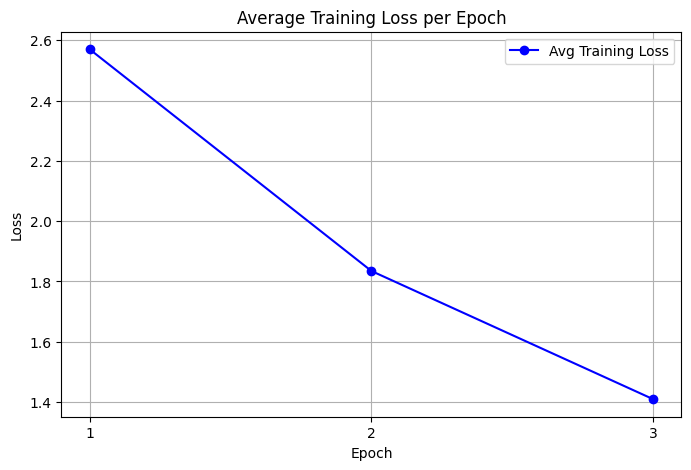

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), epoch_avg_losses, marker='o', linestyle='-', color='blue', label='Avg Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Training Loss per Epoch')
plt.xticks(range(1, epochs + 1))
plt.grid(True)
plt.legend()
plt.show()

In [9]:
# Save the fine-tuned model
model.save_pretrained('/kaggle/working/ine_tuned_bioGPT')
tokenizer.save_pretrained('/kaggle/working/fine_tuned_bioGPT')

('/kaggle/working/fine_tuned_bioGPT/tokenizer_config.json',
 '/kaggle/working/fine_tuned_bioGPT/special_tokens_map.json',
 '/kaggle/working/fine_tuned_bioGPT/vocab.json',
 '/kaggle/working/fine_tuned_bioGPT/merges.txt',
 '/kaggle/working/fine_tuned_bioGPT/added_tokens.json')

In [10]:
from tqdm import tqdm
# Function to generate summaries
def generate_summary(text, max_new_tokens=100):  # Only control *new* generated tokens
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    output = model.generate(
        inputs['input_ids'], 
        max_new_tokens=max_new_tokens,   # use max_new_tokens, not max_length
        num_beams=4, 
        no_repeat_ngram_size=2, 
        early_stopping=True
    )
    summary = tokenizer.decode(output[0], skip_special_tokens=True)
    return summary

# Assuming you have a pandas DataFrame 'df' with the 'transcription' column
df = pd.read_csv("/kaggle/input/cleaned-data-med/mtsamples_cleaned (2).csv")  # Load your dataset
from tqdm import tqdm
df['Generated_Summary'] = [generate_summary(text) for text in tqdm(df['transcription'])]

100%|██████████| 4966/4966 [2:58:43<00:00,  2.16s/it]  


In [11]:
# Save the DataFrame with summaries
df.to_csv("/kaggle/working/dataset_with_summaries.csv", index=False)

In [12]:
# Example input text 
example_text = """The patient is a 67-year-old male with a history of hypertension and type 2 diabetes mellitus who presents with chest pain radiating to the left arm. An ECG showed ST-segment elevation consistent with myocardial infarction."""
summary = generate_summary(example_text)
print("Example Summary:\n", summary)

Example Summary:
The patient was diagnosed with ST-elevation myocardial infarction and was promptly administered thrombolytic therapy.


In [13]:
pip install rouge-score bert-score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.3 MB/s eta 0:00:00:00:0100:01
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=a3be0125ccb9c322a7e3f36bd112a9e0a863096b21709619fb868afde2a3afa2
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1

In [16]:
from rouge_score import rouge_scorer
from bert_score import score
import numpy as np

# Function to calculate ROUGE scores
def calculate_rouge_scores(predictions, references):
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    rouge_scores = {"rouge1": [], "rouge2": [], "rougeL": []}
    for pred, ref in zip(predictions, references):
        scores = scorer.score(ref, pred)
        rouge_scores["rouge1"].append(scores["rouge1"].fmeasure)
        rouge_scores["rouge2"].append(scores["rouge2"].fmeasure)
        rouge_scores["rougeL"].append(scores["rougeL"].fmeasure)
    return {key: np.mean(value) for key, value in rouge_scores.items()}

# Function to calculate BERTScore
def calculate_bertscore(predictions, references):
    P, R, F1 = score(predictions, references, lang="en")
    precision = P.mean().item()
    recall = R.mean().item()
    f1 = F1.mean().item()
    return {"precision": precision, "recall": recall, "f1": f1}

# Assuming you have your generated summaries and the original transcriptions in 'df'
predictions = df['Generated_Summary'].tolist()
references = df['transcription'].tolist()

# Calculate ROUGE scores
rouge_scores = calculate_rouge_scores(predictions, references)
print(f"ROUGE Scores: {rouge_scores}")

# Calculate BERTScore
bertscore_scores = calculate_bertscore(predictions, references)
print(f"BERTScore: Precision: {bertscore_scores['precision']}, Recall: {bertscore_scores['recall']}, F1: {bertscore_scores['f1']}")

ROUGE Scores: {'rouge1': 0.8084156865686449, 'rouge2': 0.8030543663499945, 'rougeL': 0.8065597718180176}


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore: Precision: 0.9448851943016052, Recall: 0.9899482727050781, F1: 0.9665169715881348


In [17]:
import numpy as np
from rouge_score import rouge_scorer
from bert_score import score
from tqdm import tqdm

# Load predictions and references
references = df['transcription'].fillna('').astype(str).tolist()       # Ground truth
predictions = df['Generated_Summary'].fillna('').astype(str).tolist()  # Model output

# Initialize ROUGE scorer
rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Containers for individual ROUGE scores
rouge1_scores, rouge2_scores, rougeL_scores = [], [], []

# Compute ROUGE scores
print("🔍 Calculating ROUGE scores...")
for ref, pred in tqdm(zip(references, predictions), total=len(references)):
    scores = rouge.score(ref, pred)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# Filter empty strings before BERTScore
filtered_references = []
filtered_predictions = []

for ref, pred in zip(references, predictions):
    if ref.strip() and pred.strip():
        filtered_references.append(ref)
        filtered_predictions.append(pred)

# Compute BERTScore
print("\n🔍 Calculating BERTScore...")
P, R, F1 = score(filtered_predictions, filtered_references, lang="en", verbose=True)
bert_score_p = P.tolist()
bert_score_r = R.tolist()
bert_score_f1 = F1.tolist()

# Aggregate all metrics
metrics = {
    'rouge-1': np.mean(rouge1_scores),
    'rouge-2': np.mean(rouge2_scores),
    'rouge-l': np.mean(rougeL_scores),
    'bertscore-precision': np.mean(bert_score_p),
    'bertscore-recall': np.mean(bert_score_r),
    'bertscore-f1': np.mean(bert_score_f1)
}

# Display metrics
print("\nEvaluation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

🔍 Calculating ROUGE scores...


100%|██████████| 4966/4966 [02:47<00:00, 29.63it/s]



🔍 Calculating BERTScore...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/115 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/78 [00:00<?, ?it/s]

done in 259.82 seconds, 19.11 sentences/sec

Evaluation Metrics:
rouge-1: 0.8084
rouge-2: 0.8031
rouge-l: 0.8066
bertscore-precision: 0.9449
bertscore-recall: 0.9899
bertscore-f1: 0.9665
